In [1]:
import numpy as np                      # I use this for maths and sometimes arrays.
                                        # "np" is just an abbreviation since we call this package so often!
import pylab                            # I use this for arrays and plotting
import matplotlib                       # Another plotting package
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # If there is a task you use a lot, importing it like this 
                                         # keeps you from having to constantly type "matplotlib.gridspec"
                                        # every time you call that task!
        
import scipy
import astropy.io.fits as fits          # I use this to import FITS images. 
                                        # Astropy should be included in your conda installation
from astropy.wcs import WCS             # This one helps us add coordinates to images
import pyspeckit as psk                 # I use this to do spectral line fitting
                                        #Anna: Had to install using an anaconda terminal window, its located at Users\Anna\AppData\Local\pip

from astropy.nddata import Cutout2D     #To make image cut outs
from astropy.coordinates import SkyCoord
import matplotlib.cm as cm #for colorbar??

from reproject import reproject_interp      #Anna: pip install reproject
from reproject.mosaicking import find_optimal_celestial_wcs 

import sys                 # Suppress warnings we don't care about:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
                                            
    
# Super important: This embeds plots in the Jupyter window (instead of showing them as pop-ups)
%matplotlib inline                             

#Set plot fonts
matplotlib.rc('text', usetex=True) #Change to True later if Latex is installed
matplotlib.rc('font', family='sans-serif')


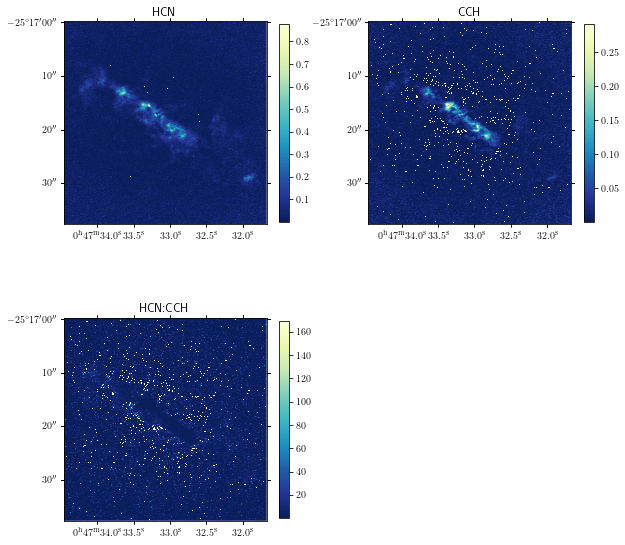

In [2]:
#Testing some noise stuff cause oh my god im confused
# 'CCH', 'HN13C', 'H13CN', 'H13COp', 'HC3N', 'SiO' _mask.integrated.fits

fig = pylab.figure(3, figsize=(10,10))

path = 'HCN_mask.integrated.fits'
HCN = fits.getdata(path)  
HCN_header = fits.getheader(path)
w = WCS(HCN_header) 

path = 'CCH_mask.integrated.fits'
CCH = fits.getdata(path)  
CCH_header = fits.getheader(path)

HCN_CCH = HCN / CCH

#HCN = image
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN')
im1 = pylab.imshow(HCN,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#CCH
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('CCH')
im5 = pylab.imshow(CCH, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_CCH
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:CCH')
im6 = pylab.imshow(HCN_CCH, cmap='YlGnBu_r') # 0-40
fig.colorbar(im6, ax=ax6, shrink=0.8)

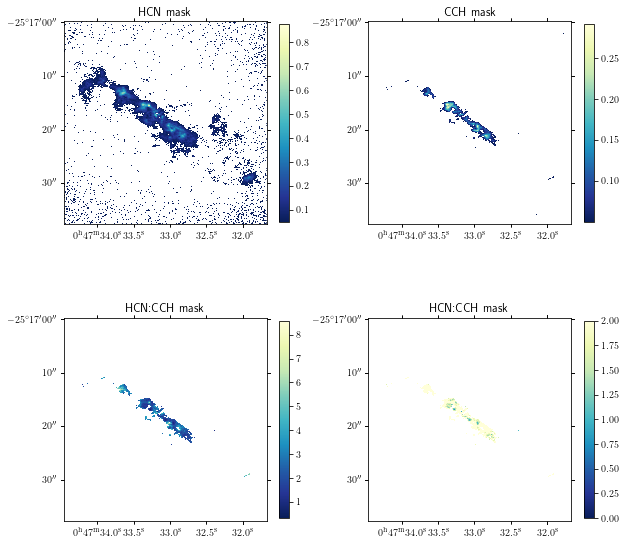

In [3]:
HCN_mask = HCN.copy()
CCH_mask = CCH.copy()

bad_pix_HCN = np.where(HCN_mask < 0.05)
bad_pix_CCH = np.where(CCH_mask < 0.05)

#NOTE!! to change what pixels are nan, MUST resest the kernal, or it won't work
HCN_mask[bad_pix_HCN] = np.nan
CCH_mask[bad_pix_CCH] = np.nan

fig = pylab.figure(4, figsize=(10,10))

#HCN_mask
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN mask')
im1 = pylab.imshow(HCN_mask,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#CCH_mask
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('CCH mask')
im5 = pylab.imshow(CCH_mask, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_CCH
HCN_CCH_mask = HCN_mask / CCH_mask
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:CCH mask')
im6 = pylab.imshow(HCN_CCH_mask, cmap='YlGnBu_r') 
fig.colorbar(im6, ax=ax6, shrink=0.8)

#HCN_CCH again,but a different range
ax6 = pylab.subplot(2,2,4,projection=w)
ax6.set_title('HCN:CCH mask')
im6 = pylab.imshow(HCN_CCH_mask, vmin = 0, vmax = 2.0, cmap='YlGnBu_r') 
fig.colorbar(im6, ax=ax6, shrink=0.8)

#Notes: set min threshold for both at 0.05, because any higher erases CCH features
#can see from first 2 subplots that there's much higher emission for HCN than CCH, so it makes sense that the ratio map
#is almost entirely above 1 in the 3rd subplot. I changed the range on the 4th subplot to see if it looks like theres
#more CCH than HCN anywhere (so less than 1 in the ration map) and it looks like there isn't, just a few clumps
#where they might be equal, maybe in the more interior regions?

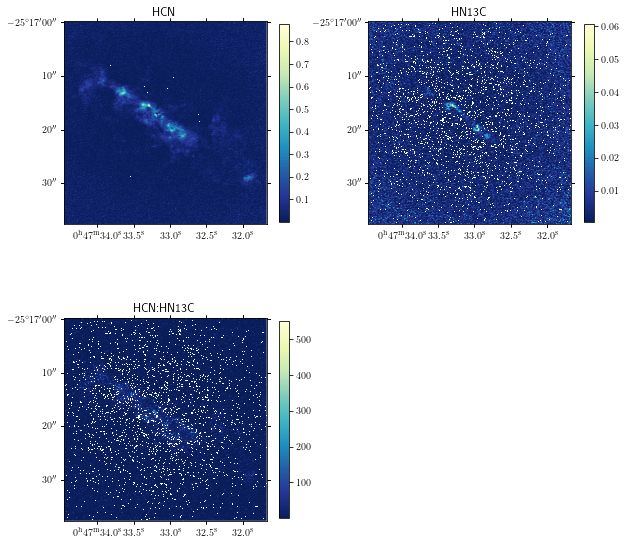

In [4]:
fig = pylab.figure(3, figsize=(10,10))

path = 'HN13C_mask.integrated.fits'
HN13C = fits.getdata(path)  
HN13C_header = fits.getheader(path)

HCN_HN13C = HCN / HN13C

#HCN
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN')
im1 = pylab.imshow(HCN,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#HN13C
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('HN13C')
im5 = pylab.imshow(HN13C, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_HN13C
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:HN13C')
im6 = pylab.imshow(HCN_HN13C, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

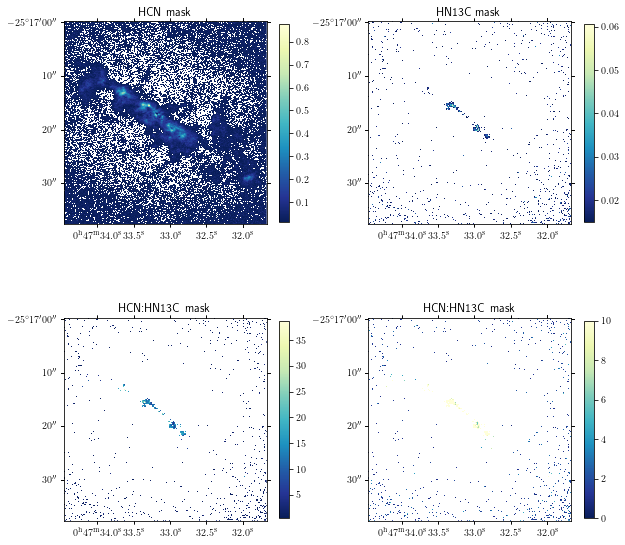

In [5]:
HCN_mask = HCN.copy()
HN13C_mask = HN13C.copy()

bad_pix_HCN = np.where(HCN_mask < 0.015)
bad_pix_HN13C = np.where(HN13C_mask < 0.015)

#NOTE!! to change what pixels are nan, MUST resest the kernal, or it won't work
HCN_mask[bad_pix_HCN] = np.nan
HN13C_mask[bad_pix_HN13C] = np.nan

fig = pylab.figure(4, figsize=(10,10))

#HCN_mask
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN mask')
im1 = pylab.imshow(HCN_mask,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#HN13C_mask
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('HN13C mask')
im5 = pylab.imshow(HN13C_mask, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_HN13C
HCN_HN13C_mask = HCN_mask / HN13C_mask
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:HN13C mask')
im6 = pylab.imshow(HCN_HN13C_mask, cmap='YlGnBu_r') 
fig.colorbar(im6, ax=ax6, shrink=0.8)

#HCN_HN13C again,but a different range
ax6 = pylab.subplot(2,2,4,projection=w)
ax6.set_title('HCN:HN13C mask')
im6 = pylab.imshow(HCN_HN13C_mask, vmin = 0, vmax = 10.0, cmap='YlGnBu_r') 
fig.colorbar(im6, ax=ax6, shrink=0.8)

#Notes: 

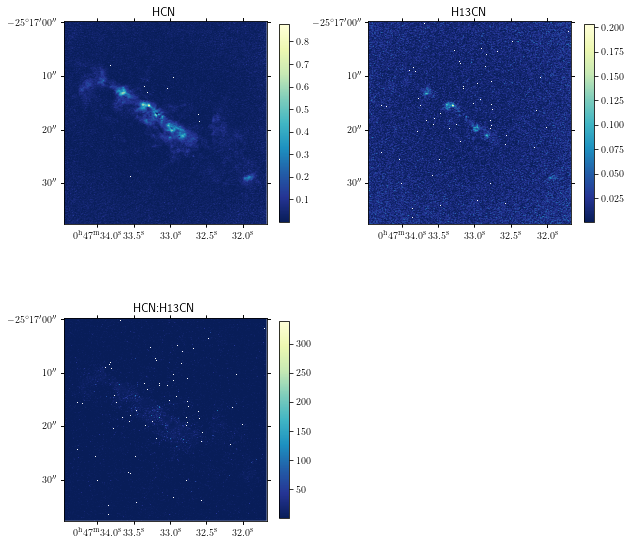

In [6]:
fig = pylab.figure(3, figsize=(10,10))

path = 'HCN_mask.integrated.fits'
HCN = fits.getdata(path)  
HCN_header = fits.getheader(path)
w = WCS(HCN_header) 

path = 'H13CN_mask.integrated.fits'
H13CN = fits.getdata(path)  
H13CN_header = fits.getheader(path)

HCN_H13CN = HCN / H13CN

#HCN = image
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN')
im1 = pylab.imshow(HCN,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#H13CN
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('H13CN')
im5 = pylab.imshow(H13CN, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_H13CN
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:H13CN')
im6 = pylab.imshow(HCN_H13CN, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

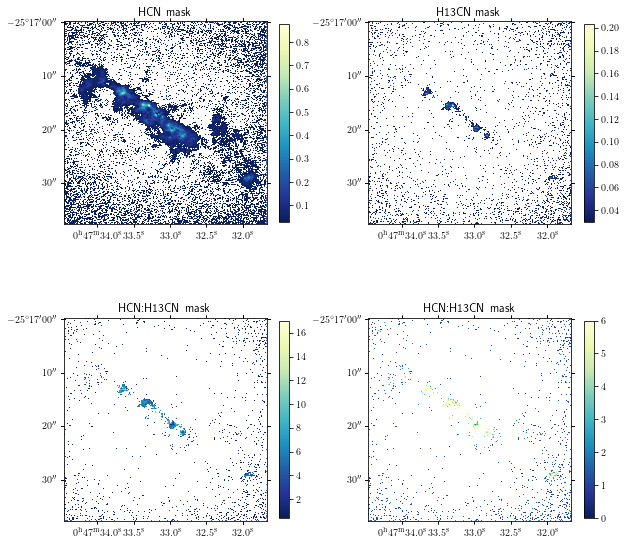

In [7]:
HCN_mask = HCN.copy()
H13CN_mask = H13CN.copy()

bad_pix_HCN = np.where(HCN_mask < 0.03)
bad_pix_H13CN = np.where(H13CN_mask < 0.03)

#NOTE!! to change what pixels are nan, MUST resest the kernal, or it won't work
HCN_mask[bad_pix_HCN] = np.nan
H13CN_mask[bad_pix_H13CN] = np.nan

fig = pylab.figure(4, figsize=(10,10))

#HCN_mask
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN mask')
im1 = pylab.imshow(HCN_mask,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#H13CN
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('H13CN mask')
im5 = pylab.imshow(H13CN_mask, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_H13CN
HCN_H13CN_mask = HCN_mask / H13CN_mask
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:H13CN mask')
im6 = pylab.imshow(HCN_H13CN_mask, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#HCN_H13CN ranged
ax6 = pylab.subplot(2,2,4,projection=w)
ax6.set_title('HCN:H13CN mask')
im6 = pylab.imshow(HCN_H13CN_mask, vmin = 0, vmax = 6, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#Notes: 

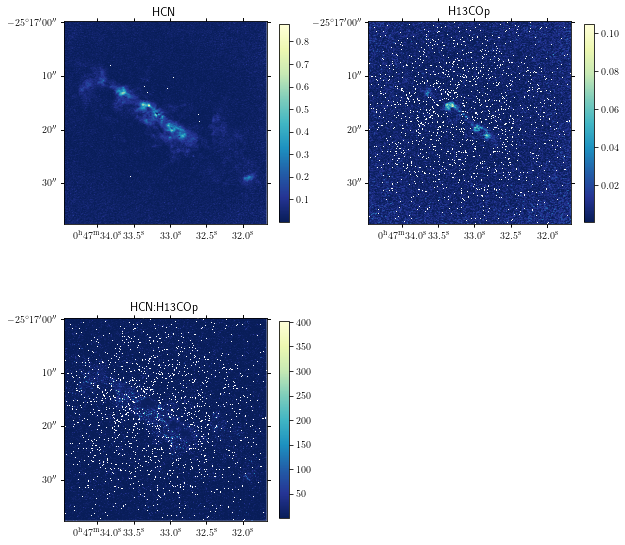

In [8]:
#H13COp
fig = pylab.figure(3, figsize=(10,10))

path = 'HCN_mask.integrated.fits'
HCN = fits.getdata(path)  
HCN_header = fits.getheader(path)
w = WCS(HCN_header) 

path = 'H13COp_mask.integrated.fits'
H13COp = fits.getdata(path)  
H13COp_header = fits.getheader(path)

HCN_H13COp = HCN / H13COp

#HCN = image
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN')
im1 = pylab.imshow(HCN,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#H13COp
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('H13COp')
im5 = pylab.imshow(H13COp, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_H13COp
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:H13COp')
im6 = pylab.imshow(HCN_H13COp, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

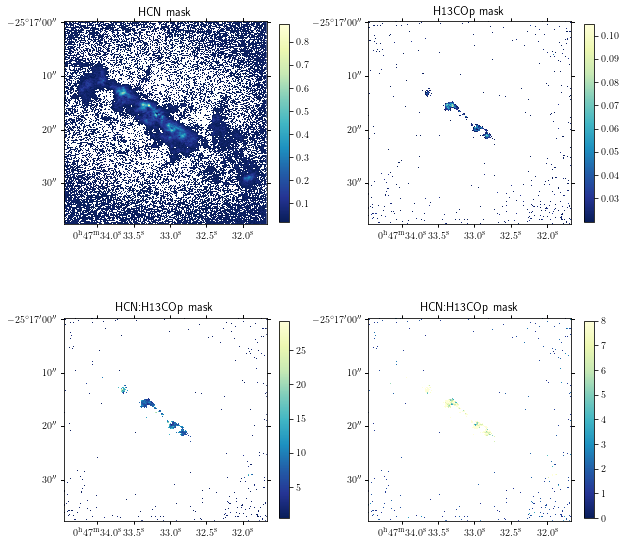

In [9]:
HCN_mask = HCN.copy()
H13COp_mask = H13COp.copy()

bad_pix_HCN = np.where(HCN_mask < 0.02)
bad_pix_H13COp = np.where(H13COp_mask < 0.02)

#NOTE!! to change what pixels are nan, MUST resest the kernal, or it won't work
HCN_mask[bad_pix_HCN] = np.nan
H13COp_mask[bad_pix_H13COp] = np.nan

fig = pylab.figure(4, figsize=(10,10))

#HCN_mask
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN mask')
im1 = pylab.imshow(HCN_mask,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#H13COp mask
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('H13COp mask')
im5 = pylab.imshow(H13COp_mask, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_H13COp_mask
HCN_H13COp_mask = HCN_mask / H13COp_mask
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:H13COp mask')
im6 = pylab.imshow(HCN_H13COp_mask, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#HCN_H13CN ranged
ax6 = pylab.subplot(2,2,4,projection=w)
ax6.set_title('HCN:H13COp mask')
im6 = pylab.imshow(HCN_H13COp_mask, vmin = 0, vmax = 8, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#Notes: 

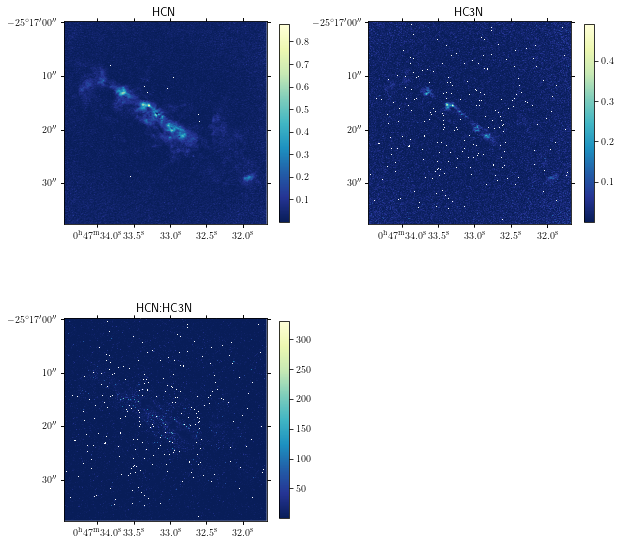

In [10]:
#HC3N
fig = pylab.figure(3, figsize=(10,10))

path = 'HCN_mask.integrated.fits'
HCN = fits.getdata(path)  
HCN_header = fits.getheader(path)
w = WCS(HCN_header) 

path = 'HC3N_mask.integrated.fits'
HC3N = fits.getdata(path)  
HC3N_header = fits.getheader(path)

HCN_HC3N = HCN / HC3N

#HCN = image
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN')
im1 = pylab.imshow(HCN,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#HC3N
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('HC3N')
im5 = pylab.imshow(HC3N, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_HC3N
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:HC3N')
im6 = pylab.imshow(HCN_HC3N, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

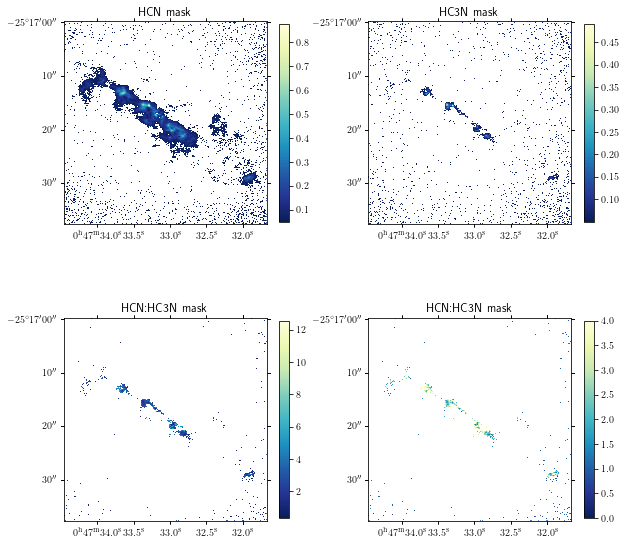

In [11]:
#HC3N
HCN_mask = HCN.copy()
HC3N_mask = HC3N.copy()

bad_pix_HCN = np.where(HCN_mask < 0.05)
bad_pix_HC3N = np.where(HC3N_mask < 0.05)

#NOTE!! to change what pixels are nan, MUST resest the kernal, or it won't work
HCN_mask[bad_pix_HCN] = np.nan
HC3N_mask[bad_pix_HC3N] = np.nan

fig = pylab.figure(4, figsize=(10,10))

#HCN_mask
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN mask')
im1 = pylab.imshow(HCN_mask,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#HC3N mask
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('HC3N mask')
im5 = pylab.imshow(HC3N_mask, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_HC3N_mask
HCN_HC3N_mask = HCN_mask / HC3N_mask
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:HC3N mask')
im6 = pylab.imshow(HCN_HC3N_mask, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#HCN_H13CN ranged
ax6 = pylab.subplot(2,2,4,projection=w)
ax6.set_title('HCN:HC3N mask')
im6 = pylab.imshow(HCN_HC3N_mask, vmin = 0, vmax = 4, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#Notes: 

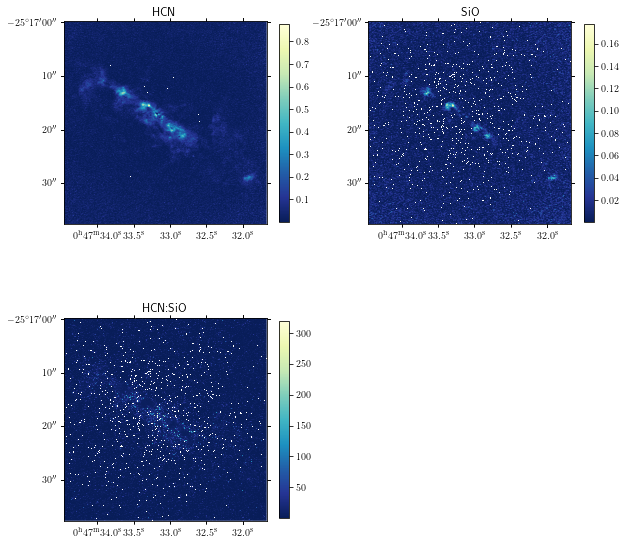

In [12]:
#SiO
fig = pylab.figure(3, figsize=(10,10))

path = 'HCN_mask.integrated.fits'
HCN = fits.getdata(path)  
HCN_header = fits.getheader(path)
w = WCS(HCN_header) 

path = 'SiO_mask.integrated.fits'
SiO = fits.getdata(path)  
SiO_header = fits.getheader(path)

HCN_SiO = HCN / SiO

#HCN = image
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN')
im1 = pylab.imshow(HCN,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#SiO
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('SiO')
im5 = pylab.imshow(SiO, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_SiO
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:SiO')
im6 = pylab.imshow(HCN_SiO, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

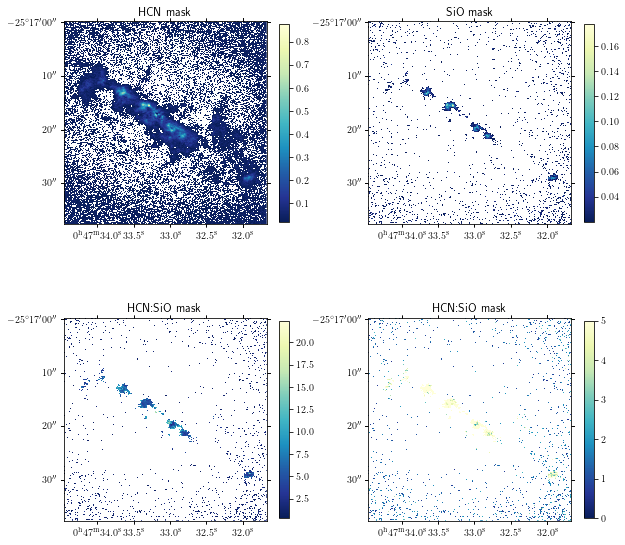

In [13]:
#SiO
HCN_mask = HCN.copy()
SiO_mask = SiO.copy()

bad_pix_HCN = np.where(HCN_mask < 0.02)
bad_pix_SiO = np.where(SiO_mask < 0.02)

#NOTE!! to change what pixels are nan, MUST resest the kernal, or it won't work
HCN_mask[bad_pix_HCN] = np.nan
SiO_mask[bad_pix_SiO] = np.nan

fig = pylab.figure(4, figsize=(10,10))

#HCN_mask
ax1 = pylab.subplot(2,2,1,projection=w) 
ax1.set_title('HCN mask')
im1 = pylab.imshow(HCN_mask,cmap='YlGnBu_r')
fig.colorbar(im1, ax=ax1, shrink=0.8)

#SiO mask
ax5 = pylab.subplot(2,2,2,projection=w)
ax5.set_title('SiO mask')
im5 = pylab.imshow(SiO_mask, cmap='YlGnBu_r')
fig.colorbar(im5, ax=ax5, shrink=0.8)

#HCN_SiO_mask
HCN_SiO_mask = HCN_mask / SiO_mask
ax6 = pylab.subplot(2,2,3,projection=w)
ax6.set_title('HCN:SiO mask')
im6 = pylab.imshow(HCN_SiO_mask, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#HCN_H13CN ranged
ax6 = pylab.subplot(2,2,4,projection=w)
ax6.set_title('HCN:SiO mask')
im6 = pylab.imshow(HCN_SiO_mask, vmin = 0, vmax = 5, cmap='YlGnBu_r')
fig.colorbar(im6, ax=ax6, shrink=0.8)

#Notes: 